# 2.5D data

* [UWMGI: 2.5D stride=2 Data](https://www.kaggle.com/code/awsaf49/uwmgi-2-5d-stride-2-data) (参考にしたnotebook)
* 前後のスライスを考慮した2.5Dのデータが有効らしい

* 2022/06/16 修正 imgのほうもresizeして保存する必要がある

In [1]:
from google.colab import drive
drive.mount("/content/drive")
%cd /content/drive/MyDrive/kaggle/UWMGI/

# シンボリックリンクを作成
!ln -sfn /content/drive/MyDrive/kaggle/UWMGI/ /content/workspace
# install vim
!apt-get install vim
# kaggle api
!pip install kaggle
#!wandb login $WANDB_API_KEY

# current directory 変更
import os
# path を通す
import sys
sys.path.append("../")

# import したもの自動reloadする設定
%load_ext autoreload
%autoreload 2

os.environ["KAGGLE_CONFIG_DIR"] = "/content/workspace"

In [2]:
import numpy as np
import pandas as pd
pd.options.plotting.backend = "plotly"
import random
from glob import glob
import os, shutil
from tqdm.notebook import tqdm
tqdm.pandas()
import time
import copy
import joblib
import gc
from IPython import display as ipd
from joblib import Parallel, delayed
import h5py

# visualization
import cv2 as cv
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
# --- Custom Color Maps ---
# Yellow Purple Red
labels = ["Large Bowel", "Small Bowel", "Stomach"]

import matplotlib.colors as colors
from matplotlib.colors import LinearSegmentedColormap

# Custom color map in matplotlib
mask_colors = [(1.0, 0.7, 0.1), (1.0, 0.5, 1.0), (1.0, 0.22, 0.099)]
legend_colors = [Rectangle((0,0),1,1, color=color) for color in mask_colors]
def CustomCmap(rgb_color):

    r1,g1,b1 = rgb_color

    cdict = {'red': ((0, r1, r1),
                   (1, r1, r1)),
           'green': ((0, g1, g1),
                    (1, g1, g1)),
           'blue': ((0, b1, b1),
                   (1, b1, b1))}

    cmap = LinearSegmentedColormap('custom_cmap', cdict)
    # １以外の部分は表示しない
    cmap_lis = cmap(np.arange(cmap.N))
    cmap_lis[:, 3] = 0
    cmap_lis[-1, 3] = 1
    cmap = colors.ListedColormap(cmap_lis)
    return cmap

CMAP1 = CustomCmap(mask_colors[0])
CMAP2 = CustomCmap(mask_colors[1])
CMAP3 = CustomCmap(mask_colors[2])

In [3]:
# max_height 310, max_width 360
IMG_SIZE = [320, 384]

HDF5_FILE_PATH = "./data/dataset.hdf5"

#IMAGE

In [5]:
def load_img(id, size=IMG_SIZE, hdf5_path=HDF5_FILE_PATH):
    """load and resize image
    size: default (320, 384)
    """
    f = h5py.File(hdf5_path, 'r')
    img = f[f"/img/{id}"][...]
    f.close()
    img = img.astype("float32")
    # size
    shape0 = np.array(img.shape[:2])
    resize = np.array(size)
    # if shape0 and IMG_SIZE are not same
    if np.any(shape0 != resize):
        diff = resize - shape0
        # diff y axis
        pad0 = diff[0]
        # diff x axis
        pad1 = diff[1]
        pady = [pad0 // 2, pad0 // 2 + pad0 % 2]
        padx = [pad1 // 2, pad1 // 2 + pad1 % 2]
        img = np.pad(img, [pady, padx])
        img = img.reshape(size)

    mx = img.max()
    if mx:
        img /= mx
    return img

def load_msk(id, size=IMG_SIZE, hdf5_path=HDF5_FILE_PATH):
    """load and resize 3Dmask
    size: default = IMG_SIZE"""
    f = h5py.File(hdf5_path, 'r')
    msk = f[f"/mask3D/{id}"][...]
    f.close()
    msk = msk.astype('float32')
#     msk/=255.0
#     msk = cv2.resize(msk, dsize=size, interpolation=cv2.INTER_NEAREST)
    shape0 = np.array(msk.shape[:2])
    resize = np.array(size)
    if np.any(shape0!=resize):
        diff = resize - shape0
        pad0 = diff[0]
        pad1 = diff[1]
        pady = [pad0//2, pad0//2 + pad0%2]
        padx = [pad1//2, pad1//2 + pad1%2]
        msk = np.pad(msk, [pady, padx, [0,0]])
        msk = msk.reshape((size[0], size[1], 3))
    mx = msk.max()
    if mx:
        msk /= mx
    return msk

def show_img(ax, img, mask=None):
    """show image and mask simultanously
    """
    ax.imshow(img, cmap="gist_gray")
    if mask is not None:
        # ax.imshow(np.ma.masked_where(mask!=1, mask), alpha=0.5, cmap='autumn')
        mask = np.where(mask != 0.0, mask, np.nan)
        ax.imshow(mask, alpha=0.3)
        handles = [Rectangle((0,0),1,1, color=_c) for _c in [(0.667,0.0,0.0), (0.0,0.667,0.0), (0.0,0.0,0.667)]]
        labels = [ "Large Bowel", "Small Bowel", "Stomach"]
        ax.legend(handles,labels)
    ax.axis('off')

def read_image(path):
    """
    intput path: str
    output image: numpy array
    without padding treatment
    """
    image = cv.imread(path, cv.IMREAD_UNCHANGED).astype("float32")
    # Scale to [0, 255]
    image = cv.normalize(image, None, alpha = 0, beta = 255, 
                        norm_type = cv.NORM_MINMAX, dtype = cv.CV_32F)
    image = image.astype(np.uint8)
    return image

def load_imgs(ids_lis, size=IMG_SIZE):
    """
    ids_lis: ids list for 2D mask path to make 2.5D images
    return
    imgs: return 2.5D imgs
    """
    imgs = np.zeros((*size, len(ids_lis)), dtype=np.float32)
    for i, id in enumerate(ids_lis):
        img = load_img(id, size=size)
        img = img.astype(np.float32)
        imgs[..., i]+=img
    return imgs

# VISUALIZATION

In [6]:
def show_simple_images(sample_paths):
    """
    input sample_paths: list of paths
    output figure
    """
    # get meta data from path
    case_name = [info.split("_")[0][-7:] for info in sample_paths]
    day_name = [info.split("_")[1].split("/")[0] for info in sample_paths]
    slice_name = [info.split("_")[2] for info in sample_paths]

    # plot
    fig, axs = plt.subplots(2, 5, figsize=(23, 8))
    axs = axs.flatten()
    for k, path in enumerate(sample_paths):
        title = f"{k+1}. {case_name[k]} - {day_name[k]} - {slice_name[k]}"
        axs[k].set_title(title, fontsize = 14, weight='bold')
        img = read_image(path)
        axs[k].imshow(img)
        axs[k].axis("off")
    fig.tight_layout()
    fig.show()

def mask_from_segmentation(segmentation, shape):
    """
    Return the mask corresponging to the inputed segmentation
    segmentation: list of start points and length in this order
    shape: the shape to be taken by the mask
    return : 2D mask
    """
    segm = np.asarray(segmentation.split(), dtype=int)
    # 0-index
    start_point = segm[0::2] - 1
    length_point = segm[1::2]

    end_point = start_point + length_point

    case_mask = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for start, end in zip(start_point, end_point):
        case_mask[start:end] = 1
    
    case_mask = case_mask.reshape((shape[0], shape[1]))
    return case_mask

def plot_original_mask(img, mask, alpha=1):
    # Change pixels - when 1 make True, when 0 make NA
    #mask = np.where(mask == 1, mask, np.nan)

    # Split the channels
    mask_largeB = mask[:, :, 0]
    mask_smallB = mask[:, :, 1]
    mask_stomach = mask[:, :, 2]

    # Plot the 2 images (Original and with Mask)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    # Original
    ax1.set_title("Original Image")
    ax1.imshow(img, cmap="gist_gray")
    ax1.axis("off")

    # With Mask
    ax2.set_title("Image with Mask")
    ax2.imshow(img, cmap="gist_gray")
    ax2.imshow(mask_largeB, interpolation='none', cmap=CMAP1, alpha=alpha)
    ax2.imshow(mask_smallB, interpolation='none', cmap=CMAP2, alpha=alpha)
    ax2.imshow(mask_stomach, interpolation='none', cmap=CMAP3, alpha=alpha)
    ax2.legend(legend_colors, labels)
    ax2.axis("off")
    
    fig.show()

def plot_masks_chronologic(imgs, masks, ids, alpha=1):
    """
    imgs: list of images
    masks: list of masks
    ids: list of slices to get meta data(slice number)
    """
    slices = [i.split("_")[-1] for i in ids]
    
    # Plot
    fig, axs = plt.subplots(2, 5, figsize=(23, 11))
    axs = axs.flatten()
    
    for k, (img, mask) in enumerate(zip(imgs, masks)):

        # Change pixels - when 1 make True, when 0 make NA
        mask = np.where(mask == 1, mask, np.nan)

        # Split the channels
        mask_largeB = mask[:, :, 0]
        mask_smallB = mask[:, :, 1]
        mask_stomach = mask[:, :, 2]
        
        title = f"{k+1}. Slice {slices[k]}"
        axs[k].set_title(title, fontsize = 16, 
                         color = "green", weight='bold')

        axs[k].imshow(img, cmap="gist_gray")
        axs[k].axis("off")
        axs[k].imshow(mask_largeB, interpolation='none', cmap=CMAP1, alpha=alpha)
        axs[k].imshow(mask_smallB, interpolation='none', cmap=CMAP2, alpha=alpha)
        axs[k].imshow(mask_stomach, interpolation='none', cmap=CMAP3, alpha=alpha)
        axs[k].axis("off")
    
    axs[0].legend(legend_colors, labels, loc=2)
    fig.tight_layout()
    fig.show()

# meta data

In [8]:
train = pd.read_csv("./data/train_v3.csv")
train = train.loc[~train["id"].duplicated(), :]
train.drop(columns="class", inplace=True)
train.reset_index(drop=True, inplace=True)

def collect_image(x, diff):
    # x is a data frame of group value
    # diff must be plus value
    # get slice + diff further images
    x["slice"] = x["slice"].astype(int)
    x.sort_values(by="slice", inplace=True)
    x.reset_index(drop=True, inplace=True)
    x[f"imgs_for_2.5D_{diff}"] = x["path"].shift(-diff).fillna(method="ffill")
    return x

# image + image(slice + 2) + image(slice + 4)
CHANNELS = 3
STRIDE = 2
for c in range(CHANNELS):
    train = train.groupby(["case", "day"]).apply(lambda x: collect_image(x, c * STRIDE))
    train.reset_index(drop=True, inplace=True)

# 2.5D用のデータをまとめる
train["imgs_for_2.5D_list"] = train[[f"imgs_for_2.5D_{STRIDE * i}" for i in range(CHANNELS)]].values.tolist()
train.head()

,id,segmentation,case,day,slice,path,image_height,image_width,pixel_height,pixel_width,device_type,exist_segmentation,mask3D_path,mask2D_path,imgs_for_2.5D_0,imgs_for_2.5D_2,imgs_for_2.5D_4,imgs_for_2.5D_list
0,case2_day1_slice_0001,NaN,2,1,1,./data/train/case2/case2_day1/scans/slice_0001...,266,266,1.5,1.5,1,False,./data/masks_png/case2_day1_slice_0001.png,./data/masks2D_png/case2_day1_slice_0001.png,./data/train/case2/case2_day1/scans/slice_0001...,./data/train/case2/case2_day1/scans/slice_0003...,./data/train/case2/case2_day1/scans/slice_0005...,[./data/train/case2/case2_day1/scans/slice_000...
1,case2_day1_slice_0002,NaN,2,1,2,./data/train/case2/case2_day1/scans/slice_0002...,266,266,1.5,1.5,1,False,./data/masks_png/case2_day1_slice_0002.png,./data/masks2D_png/case2_day1_slice_0002.png,./data/train/case2/case2_day1/scans/slice_0002...,./data/train/case2/case2_day1/scans/slice_0004...,./data/train/case2/case2_day1/scans/slice_0006...,[./data/train/case2/case2_day1/scans/slice_000...
2,case2_day1_slice_0003,NaN,2,1,3,./data/train/case2/case2_day1/scans/slice_0003...,266,266,1.5,1.5,1,False,./data/masks_png/case2_day1_slice_0003.png,./data/masks2D_png/case2_day1_slice_0003.png,./data/train/case2/case2_day1/scans/slice_0003...,./data/train/case2/case2_day1/scans/slice_0005...,./data/train/case2/case2_day1/scans/slice_0007...,[./data/train/case2/case2_day1/scans/slice_000...
3,case2_day1_slice_0004,NaN,2,1,4,./data/train/case2/case2_day1/scans/slice_0004...,266,266,1.5,1.5,1,False,./data/masks_png/case2_day1_slice_0004.png,./data/masks2D_png/case2_day1_slice_0004.png,./data/train/case2/case2_day1/scans/slice_0004...,./data/train/case2/case2_day1/scans/slice_0006...,./data/train/case2/case2_day1/scans/slice_0008...,[./data/train/case2/case2_day1/scans/slice_000...
4,case2_day1_slice_0005,NaN,2,1,5,./data/train/case2/case2_day1/scans/slice_0005...,266,266,1.5,1.5,1,False,./data/masks_png/case2_day1_slice_0005.png,./data/masks2D_png/case2_day1_slice_0005.png,./data/train/case2/case2_day1/scans/slice_0005...,./data/train/case2/case2_day1/scans/slice_0007...,./data/train/case2/case2_day1/scans/slice_0009...,[./data/train/case2/case2_day1/scans/slice_000...


In [9]:
train = pd.read_csv("./data/train_v3.csv")
train = train.loc[~train["id"].duplicated(), :]
train.drop(columns="class", inplace=True)
train.reset_index(drop=True, inplace=True)

def collect_image(x, diff):
    # x is a data frame of group value
    # diff must be plus value
    # get slice + diff further images
    x["slice"] = x["slice"].astype(int)
    x.sort_values(by="slice", inplace=True)
    x.reset_index(drop=True, inplace=True)
    x[f"ids_for_2.5D_{diff}"] = x["id"].shift(-diff).fillna(method="ffill")
    return x

# image + image(slice + 2) + image(slice + 4)
CHANNELS = 3
STRIDE = 2
for c in range(CHANNELS):
    train = train.groupby(["case", "day"]).apply(lambda x: collect_image(x, c * STRIDE))
    train.reset_index(drop=True, inplace=True)

# 2.5D用のデータをまとめる
train["ids_for_2.5D_list"] = train[[f"ids_for_2.5D_{STRIDE * i}" for i in range(CHANNELS)]].values.tolist()
train.head()

,id,segmentation,case,day,slice,path,image_height,image_width,pixel_height,pixel_width,device_type,exist_segmentation,mask3D_path,mask2D_path,ids_for_2.5D_0,ids_for_2.5D_2,ids_for_2.5D_4,ids_for_2.5D_list
0,case2_day1_slice_0001,NaN,2,1,1,./data/train/case2/case2_day1/scans/slice_0001...,266,266,1.5,1.5,1,False,./data/masks_png/case2_day1_slice_0001.png,./data/masks2D_png/case2_day1_slice_0001.png,case2_day1_slice_0001,case2_day1_slice_0003,case2_day1_slice_0005,"[case2_day1_slice_0001, case2_day1_slice_0003,..."
1,case2_day1_slice_0002,NaN,2,1,2,./data/train/case2/case2_day1/scans/slice_0002...,266,266,1.5,1.5,1,False,./data/masks_png/case2_day1_slice_0002.png,./data/masks2D_png/case2_day1_slice_0002.png,case2_day1_slice_0002,case2_day1_slice_0004,case2_day1_slice_0006,"[case2_day1_slice_0002, case2_day1_slice_0004,..."
2,case2_day1_slice_0003,NaN,2,1,3,./data/train/case2/case2_day1/scans/slice_0003...,266,266,1.5,1.5,1,False,./data/masks_png/case2_day1_slice_0003.png,./data/masks2D_png/case2_day1_slice_0003.png,case2_day1_slice_0003,case2_day1_slice_0005,case2_day1_slice_0007,"[case2_day1_slice_0003, case2_day1_slice_0005,..."
3,case2_day1_slice_0004,NaN,2,1,4,./data/train/case2/case2_day1/scans/slice_0004...,266,266,1.5,1.5,1,False,./data/masks_png/case2_day1_slice_0004.png,./data/masks2D_png/case2_day1_slice_0004.png,case2_day1_slice_0004,case2_day1_slice_0006,case2_day1_slice_0008,"[case2_day1_slice_0004, case2_day1_slice_0006,..."
4,case2_day1_slice_0005,NaN,2,1,5,./data/train/case2/case2_day1/scans/slice_0005...,266,266,1.5,1.5,1,False,./data/masks_png/case2_day1_slice_0005.png,./data/masks2D_png/case2_day1_slice_0005.png,case2_day1_slice_0005,case2_day1_slice_0007,case2_day1_slice_0009,"[case2_day1_slice_0005, case2_day1_slice_0007,..."


* check mask

case135_day17_slice_0097 (320, 384) (320, 384, 3)
case110_day16_slice_0069 (320, 384) (320, 384, 3)
case74_day19_slice_0088 (320, 384) (320, 384, 3)
case138_day12_slice_0109 (320, 384) (320, 384, 3)


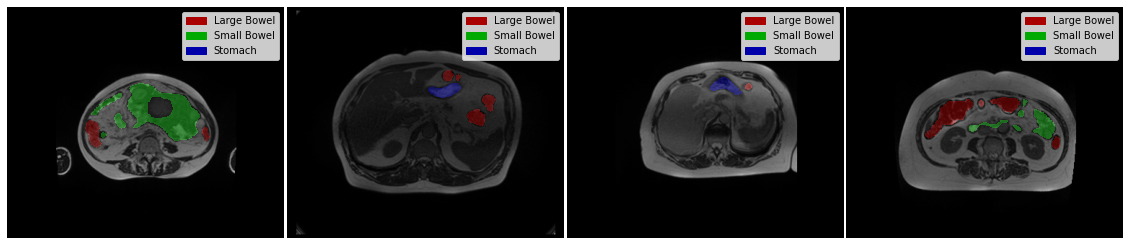

In [10]:
row=1; col=4
fig, axes = plt.subplots(row, col, figsize=(5 * col,  5 * row))
fig.subplots_adjust(wspace=0.01, hspace=0.1)
axes = axes.flatten()
for i, id in enumerate(train.loc[train["exist_segmentation"] == True, "id"].sample(frac=1.0).unique()[:row * col]):
    # original image
    img = load_img(id)
    # 3D mask image which already created
    mask = load_msk(id)
    show_img(axes[i], img, mask=mask)
    print(id, img.shape, mask.shape)

(320, 384) (320, 384, 3)


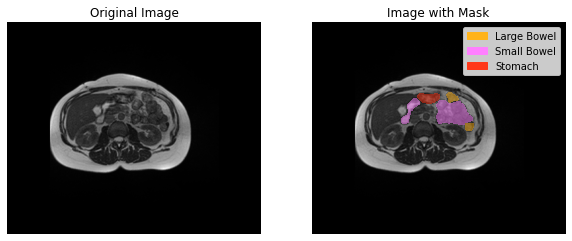

In [11]:
ids = train.loc[train["exist_segmentation"] == True, "id"].sample(frac=1.0).reset_index(drop=True).tolist()
id = ids[0]
img = load_img(id)
mask3D = load_msk(id)

plot_original_mask(img, mask3D, alpha=0.5)
print(img.shape, mask3D.shape)

# check 2.5D images
* 自分のうしろ2枚のスライスを追加したもの

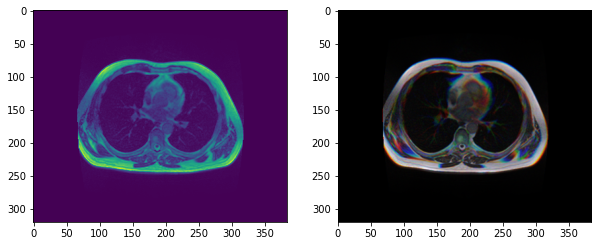

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5 * 2, 5))

ID = "case123_day20_slice_0041"
img = load_img(ID)
ax1.imshow(img)

mask25d_path = train.loc[train["id"] == "case123_day20_slice_0041", "ids_for_2.5D_list"].values[0]
mask25d_imgs = load_imgs(mask25d_path)
ax2.imshow(mask25d_imgs)

# save 2.5D imgs

In [14]:
# これ実は2.5D imageの保存のやつ
def save_25Dimgs(id, save_file):
    """
    id (str) : patient ID
    save_file (hdf5 file object) : hdf5 file object into save file
    """
    imgs_25d_lis = train.loc[train["id"] == id, "ids_for_2.5D_list"].values[0]
    imgs = load_imgs(imgs_25d_lis)
    save_file.create_dataset(name=id, data=imgs, dtype=imgs.dtype, compression="gzip")
    return

In [13]:
with h5py.File("./data/dataset.hdf5", mode = 'r') as f:
    print(f.keys())

<KeysViewHDF5 ['img', 'mask2D', 'mask3D']>


In [15]:
with h5py.File("./data/dataset.hdf5", mode = 'a') as f:
    f.create_group("/img25D")
    g = f.create_group("/img25D/channel3-stride2-back")
    ids = train["id"].unique()
    _ = Parallel(n_jobs = -1, backend = "threading")(delayed(save_25Dimgs)(id, g)\
                                                     for id in tqdm(ids, total = len(ids)))

  0%|          | 0/38496 [00:00<?, ?it/s]

# 2022/06/16 追記
# **maskのresizeしたやつも保存しないといけない**

In [16]:
def resize_msk(msk, size=IMG_SIZE):
    """load and resize 3Dmask
    size: default = IMG_SIZE"""
#     msk = msk.astype('float32')
#     msk/=255.0
#     msk = cv2.resize(msk, dsize=size, interpolation=cv2.INTER_NEAREST)
    shape0 = np.array(msk.shape[:2])
    resize = np.array(size)
    if np.any(shape0!=resize):
        diff = resize - shape0
        pad0 = diff[0]
        pad1 = diff[1]
        pady = [pad0//2, pad0//2 + pad0%2]
        padx = [pad1//2, pad1//2 + pad1%2]
        msk = np.pad(msk, [pady, padx, [0,0]])
        msk = msk.reshape((size[0], size[1], 3))
    return msk

def save_25D_true_mask(id, input_hdf5_dir, output_hdf5_dir):
    """
    id (str) : patient ID
    input_hdf5_dir (hdf5 file object) : input hdf5 file dir object
    output_hdf_dir (hdf5 file object) : output hdf5 file dir object
    """
    mask = input_hdf5_dir[id][...]
    mask = resize_msk(mask)
    output_hdf5_dir.create_dataset(name=id, data=mask, dtype=mask.dtype, compression="gzip")
    return

In [17]:
ids = train["id"].unique()

with h5py.File(HDF5_FILE_PATH, mode = 'a') as f:
    
    input_dir = f["mask3D"]
    
    f.create_group("/mask25D")
    output_dir = f.create_group("/mask25D/channel3-stride2-back")
    
    _ = Parallel(n_jobs = -1, backend = "threading")(delayed(save_25D_true_mask)(id, input_dir, output_dir)\
                                                     for id in tqdm(ids, total = len(ids)))

  0%|          | 0/38496 [00:00<?, ?it/s]

(320, 384, 3)
(320, 384, 3)
(320, 384, 3)


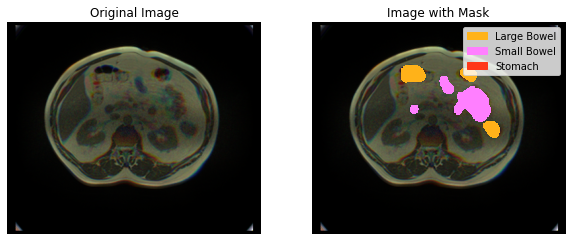

In [19]:
f = h5py.File(HDF5_FILE_PATH, 'r')
img = f["img25D/channel3-stride2-back/case19_day14_slice_0070"][...]
mask = f["/mask25D/channel3-stride2-back/case19_day14_slice_0070"][...]
print(mask.shape)
mask = resize_msk(mask)
print(mask.shape)

plot_original_mask(img, mask)
print(img.shape)
f.close()